# Offline Thai Handwritten Character Recognition using Few-shot Learning Approach

The code was adapted from EasyFSL's [First steps into few-shot image classification](https://github.com/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb)

In [1]:
# !pip install easyfsl

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot, VisionDataset
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

from os.path import join
from typing import Any, Callable, List, Optional, Tuple
from torchvision.datasets.utils import list_dir, list_files
from PIL import Image
from torchvision.transforms import functional

import matplotlib.pyplot as plt

## Datasets
### Omniglot
A popular MNIST-like benchmark for few-shot classification. It contains 1623 characters from 50 different alphabets. Each character has been written by 20 different people. 
In this notebook, we will use it as a meta-training dataset.

In [3]:
image_size = 28

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
test_set

Dataset Omniglot
    Number of datapoints: 13180
    Root location: ./data/omniglot-py
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=[32, 32], interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(28, 28))
               ToTensor()
           )

### Thai Handwritten Characters Dataset
[KVIS Thai OCR dataset](https://data.mendeley.com/datasets/8nr3pbdk5c/1) is used. There are 44 classes of characters. Its size is only 1024 with at least 12 images for each class.

In [5]:
class ThaiCharactersDataset(VisionDataset):
    """ Thai Handwritten Characters dataset """

    def __init__(
        self, 
        root: str, 
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)

        self.target_folder = root
        self._characters: List[str] = list_dir(self.target_folder) # list of character paths

        self._character_images = [
            [(image, idx) for image in list_files(join(self.target_folder, character), ".jpg")]
            for idx, character in enumerate(self._characters)
        ] # format: [ [(img, idx), (img, idx), ...], [(img, idx), (img, idx), ...], ..., [(img, idx), (img, idx), ...] ]
        
        self._flat_character_images: List[Tuple(str, int)] = sum(self._character_images, [])
    
    def __len__(self) -> int:
        return len(self._flat_character_images)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image_name, character_class = self._flat_character_images[index]
        image_path = join(self.target_folder, self._characters[character_class], image_name)
        image = Image.open(image_path, mode="r").convert("L") # ?

        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            character_class = self.target_transform(character_class)
        
        return image, character_class

class ThresholdTransform(object):
    def __init__(self, thr_255):
        self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

    def __call__(self, im):
        return (im > self.thr).to(im.dtype)  # do not change the data type

class CropTransform(object):
    # crop at the edge of character 
    # add padding a bit (optional, can separately write in transforms.Compose)
    def __init__(self, padding):
        self.padding = padding

    def __call__(self, im):
        # assume im is grayscale 3 channels
        # find coordinates to crop: top, left, h, w
        # look only at one channel
        non_white_r = []
        for i, row in enumerate(im[0]):
            if sum(row) != len(row):
                non_white_r.append(i)
        top, bottom = min(non_white_r), max(non_white_r)

        non_white_c = []
        for i, col in enumerate(torch.t(im[0])):
            if sum(col) != len(col):
                non_white_c.append(i)
        left, right = min(non_white_c), max(non_white_c)

        height = bottom - top
        width = right - left
            
        # crop
        im = functional.crop(im, top, left, height, width)

        # add some padding (white)
        im = functional.pad(im, padding=self.padding, fill=1)

        return im

- Pre-processing

The pre-processing significantly helps to improve the performance.
Each image is converted into Black-and-white, then being cropped based on the position of the character and resize to a fixed size (28x28)

In [6]:
image_size = 28

test_set_th = ThaiCharactersDataset(
    root = "./data/kvis-th-ocr/",
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            ThresholdTransform(thr_255=210),
            CropTransform(padding=3),
            transforms.ToPILImage(),
            transforms.Resize([image_size, image_size]),
            transforms.ToTensor(),
            ThresholdTransform(thr_255=210),
        ]
    )
)

test_set_th

Dataset ThaiCharactersDataset
    Number of datapoints: 1024
    Root location: ./data/kvis-th-ocr/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               ToTensor()
               ToPILImage()
               Resize(size=[28, 28], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

0


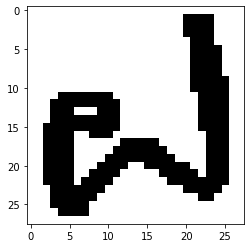

In [7]:
img, charclass = test_set_th[0]
plt.imshow(img.permute(1, 2, 0))
print(charclass)

In [8]:
root = "./data/kvis-th-ocr/"
alphabets = list_dir(root)
alphabets.sort()
s = 0
l = []
for a in alphabets:
    examples = list_files(join(root, a), ".jpg")
    s += len(examples)
    l.append( (a, len(examples)) )

print(f'num classes: {len(l)}')
print(f"total no of images: {s}")
print(sorted(l, key=lambda it: it[1])) # sort by no of images in each class

num classes: 44
total no of images: 1024
[('ฅ05', 12), ('ค04', 13), ('ฃ03', 14), ('ข02', 15), ('ฆ06', 15), ('ป27', 17), ('ฟ31', 18), ('ฏ15', 20), ('ฝ29', 21), ('ศ38', 21), ('ฌ12', 23), ('ญ13', 23), ('ส40', 23), ('ฮ44', 23), ('ฐ16', 24), ('ด20', 24), ('ก01', 25), ('ง07', 25), ('ฉ09', 25), ('ช10', 25), ('ซ11', 25), ('ฎ14', 25), ('ณ19', 25), ('ผ28', 25), ('ย34', 25), ('ร35', 25), ('ล36', 25), ('ษ39', 25), ('ฬ42', 25), ('อ43', 25), ('จ08', 26), ('ฑ17', 26), ('ฒ18', 26), ('ธ24', 26), ('น25', 26), ('บ26', 26), ('พ30', 26), ('ภ32', 26), ('ม33', 26), ('ว37', 26), ('ต21', 27), ('ถ22', 27), ('ท23', 27), ('ห41', 27)]


### Data Loader
Define data loader for each dataset. Easyfsl's `TaskSampler` is used to define sampler for data loader.

In [17]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 7  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

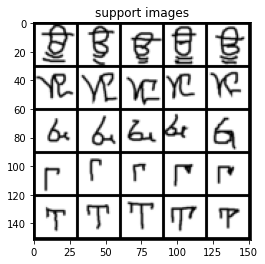

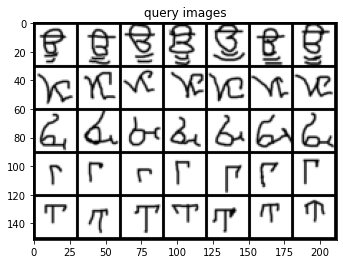

In [18]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [19]:
# Thai HCR

N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 7  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set_th.get_labels = lambda: [
    instance[1] for instance in test_set_th._flat_character_images
]
test_th_sampler = TaskSampler(
    test_set_th, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_th_loader = DataLoader(
    test_set_th,
    batch_sampler=test_th_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_th_sampler.episodic_collate_fn,
)

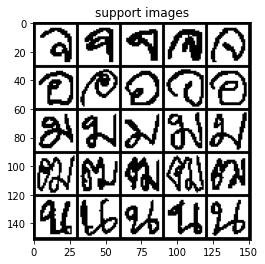

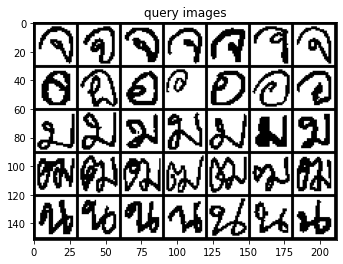

In [20]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_th_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

## Prototypical Network
- Backbone: ResNet18 pre-trained on ImageNet with head replaced with a Flatten layer
- The backbone is attached to a Prototypical Network

In [4]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


# convolutional_network = resnet18(pretrained=True)
convolutional_network = resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Evaluation of Model

Accuracy before meta-learning (depend on weights of pre-trained model)

In [22]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
    model
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader, model):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            # correct, total = evaluate_on_one_task(
            #     support_images, support_labels, query_images, query_labels
            # )
            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels, model
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader, model)

100%|██████████| 100/100 [00:02<00:00, 49.78it/s]

Model tested on 100 tasks. Accuracy: 86.34%


In [23]:
evaluate(test_th_loader, model)

100%|██████████| 100/100 [00:32<00:00,  3.12it/s]

Model tested on 100 tasks. Accuracy: 62.91%


## Training a meta-learning algorithm

In [24]:
N_TRAINING_EPISODES = 40000
# N_EVALUATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

def predict( data_loader: DataLoader, model ) -> float:
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in enumerate(data_loader):
            classification_scores = model(
            support_images.cuda(), support_labels.cuda(), query_images.cuda()
            )
            total_loss += criterion(classification_scores, query_labels.cuda())
        
        avg_loss = total_loss / N_EVALUATION_TASKS
        
    return avg_loss.item()

### Episodic Training

In [26]:
# Train the model yourself with this cell

log_update_frequency = 10
eval_update_frequency = 1000

all_loss = []
loss_train = []
loss_eval = []

with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        model.train()
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))
        
        if episode_index % eval_update_frequency == 0:
            loss_train.append(loss_value)
            loss_eval.append(predict(test_loader, model))

100%|██████████| 40000/40000 [17:01<00:00, 39.14it/s, loss=0.287]  


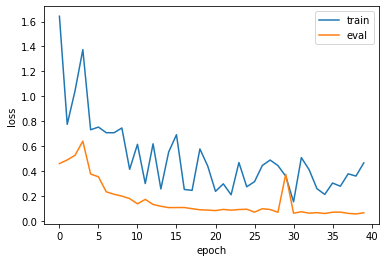

In [27]:
# Plot loss
plt.plot(range(len(loss_train)), loss_train, label="train")
plt.plot(range(len(loss_eval)), loss_eval, label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [28]:
evaluate(test_loader, model)

100%|██████████| 100/100 [00:01<00:00, 71.68it/s]

Model tested on 100 tasks. Accuracy: 97.91%


In [32]:
evaluate(test_th_loader, model)

100%|██████████| 100/100 [00:35<00:00,  2.84it/s]

Model tested on 100 tasks. Accuracy: 80.63%


## Save & Load Models

In [30]:
torch.save(model.state_dict(), "models/thaihcr_fewshot-5-5-7")

In [31]:
## Load a saved model

model_load = PrototypicalNetworks(convolutional_network).cuda()
model_load.load_state_dict(torch.load("models/thaihcr_fewshot-5-5-7", map_location="cuda"))

evaluate(test_th_loader, model_load)

100%|██████████| 100/100 [00:35<00:00,  2.84it/s]

Model tested on 100 tasks. Accuracy: 81.57%
